In [1]:
#!git clone https://github.com/NVlabs/stylegan
!git clone https://github.com/iyaja/stylegan-encoder.git

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 154, done.
remote: Total 154 (delta 0), reused 0 (delta 0), pack-reused 154
Receiving objects: 100% (154/154), 16.13 MiB | 35.44 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [0]:
!mkdir /content/stylegan-encoder/raw_images

In [3]:
%cd /content/stylegan-encoder

/content/stylegan-encoder


In [4]:
!pip install tqdm
!pip install typeguard
!pip install psutil
!pip install humanize
from IPython.display import Image
from google.colab import files
import os
import sys
import pickle
import numpy as np
import PIL.Image
from PIL import Image
import config
from tqdm import tqdm

In [5]:
sys.path.append('/content/stylegan/dnnlib')
import dnnlib
import dnnlib.tflib as tflib#pre-trained networks
dnnlib.tflib.init_tf()

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
entity_to_url={
        'faces':'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'
}
model_cache={}

In [0]:
def fetch_model(name):
  if model_cache.get(name):
    return model_cache[name]

  url = entity_to_url[name]
  with dnnlib.util.open_url(url, cache_dir='cache') as f:
    _G, _D, Gs = pickle.load(f)
    model_cache[name] = Gs
  return model_cache[name]

In [0]:
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=20)

In [10]:
seed=10000000
interpolate_dim=1#max:511
#mapping size
width=1#max:100
height=1
#image size
image_dim=100
interpolate=np.linspace(0, 30, width)
name='faces'
Gs=fetch_model(name)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def apply_latent_fudge(fudge, target_latent):
  copy=np.copy(target_latent)
  copy[interpolate_dim]+=fudge
  return copy

In [0]:
def v_linspace(i):
  v = np.array(list(map(lambda l: np.linspace(dst_dlatents[i][l], height), range(dst_dlatents.shape[1]))))
  v = v.transpose()
  return v

In [0]:
#dst:target image
def style_mixing(png, Gs, w, h, src_dlatents, dst_dlatents, style_ranges):
  print(png)
  src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
  dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

  canvas = PIL.Image.new('RGB', (w * (len(src_dlatents) + 1), h*(len(dst_dlatents) + 1)), 'white')
  for col, src_image in enumerate(list(src_images)):
    canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
  for row, dst_image in enumerate(list(dst_images)):
    canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
    row_dlatents = np.stack([dst_dlatents[row]] * len(src_dlatents))
    row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
    row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
    for col, image in enumerate(list(row_images)):
      canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
  canvas.save(png)
  return canvas.resize((512, 512))

In [0]:
test_file=np.load('/content/gdrive/My Drive/data/npy_result/hathaway_01.npy')

0


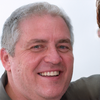

/content/stylegan-encoder
python3: can't open file 'npy_encoder.py': [Errno 2] No such file or directory


FileNotFoundError: ignored

In [15]:
for i in range(seed):
  #src_image=generate_image(seed)
  print(i)
  '''
  rnd=np.random.RandomState(i)
  init_latent1=rnd.randn(1, Gs.input_shape[1])[0]
  applier1 = lambda f: apply_latent_fudge(f, init_latent1)
  latent1=np.array(list(map(applier1, interpolate)))
  combined_latent = np.array(list(map(v_linspace, range(width))))
  combined_latent = np.array(list(map(lambda x: x.flatten(), combined_latent.transpose()))).transpose()
  images = Gs.run(combined_latent, None, **synthesis_kwargs)
  img = PIL.Image.fromarray(images[0], 'RGB')
  img = img.resize((image_dim, image_dim), PIL.Image.ANTIALIAS)
  '''
  rnd=np.random.RandomState(i)
  init_latent1=rnd.randn(1, Gs.input_shape[1])[0]
  applier1 = lambda f: apply_latent_fudge(f, init_latent1)
  latent1=np.array(list(map(applier1, interpolate)))
  image = Gs.run(latent1, None, **synthesis_kwargs)
  img = PIL.Image.fromarray(image[0], 'RGB')
  img = img.resize((image_dim, image_dim), PIL.Image.ANTIALIAS)
  display(img)
  img.save('/content/stylegan-encoder/raw_images/seed.jpg')
  
  #src_image to npy
  !python npy_encoder.py seed.jpg raw_images/ aligned_images/ generated_images/ latent_representation/
  dst_file=np.load('/content/stylegan-encoder/latent_representation/seed_ 1.npy')
  style_mixing(os.path.join('/content/gdrive/My Drive/data/style_result', 'mix_result.png'), Gs, w=1024, h=1024, src_dlatents=dst_file.reshape((1, 18, 512)), dst_dlatents=test_file.reshape((1, 18, 512)), style_ranges=[range(6, 14)])
  if i == 1:#dst_image == style_mixing(age, gender)
    break
display('mix_result.png')